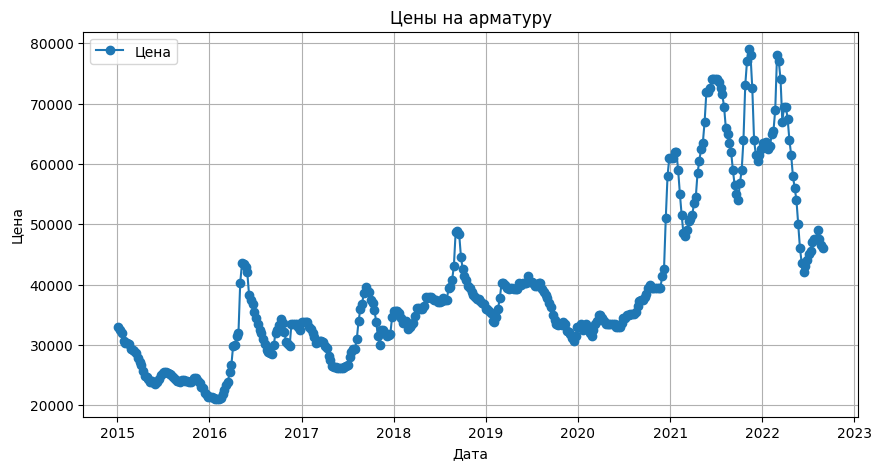

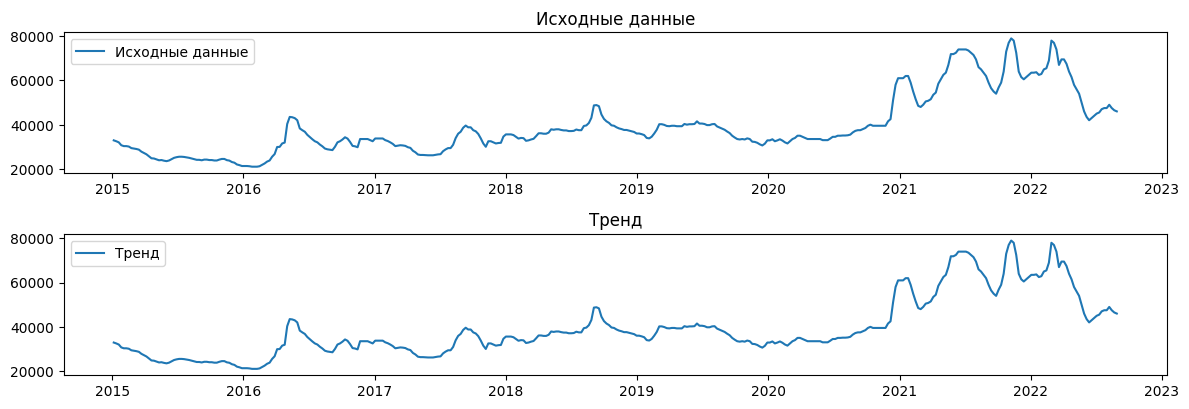

In [ ]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

df = pd.read_excel('train.xlsx')


df['date'] = pd.to_datetime(df['dt'])  # Преобразуем столбец с датами в формат datetime
df.set_index('dt', inplace=True)  # Устанавливаем дату в качестве индекса

# Выводим график исходных данных
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Цена на арматуру'], marker='o', label='Цена')
plt.title('Цены на арматуру')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.grid()
plt.legend()  # Добавляем легенду
plt.show()

# Используем STL разложение для анализа
decomposition = sm.tsa.seasonal_decompose(df['Цена на арматуру'], model='additive', period=1)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Визуализируем разложение
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(df['Цена на арматуру'], label='Исходные данные')
plt.legend(loc='upper left')
plt.title('Исходные данные')

plt.subplot(412)
plt.plot(trend, label='Тренд')
plt.legend(loc='upper left')
plt.title('Тренд')


plt.tight_layout()  # Обеспечивает хорошее размещение подграфиков
plt.show()


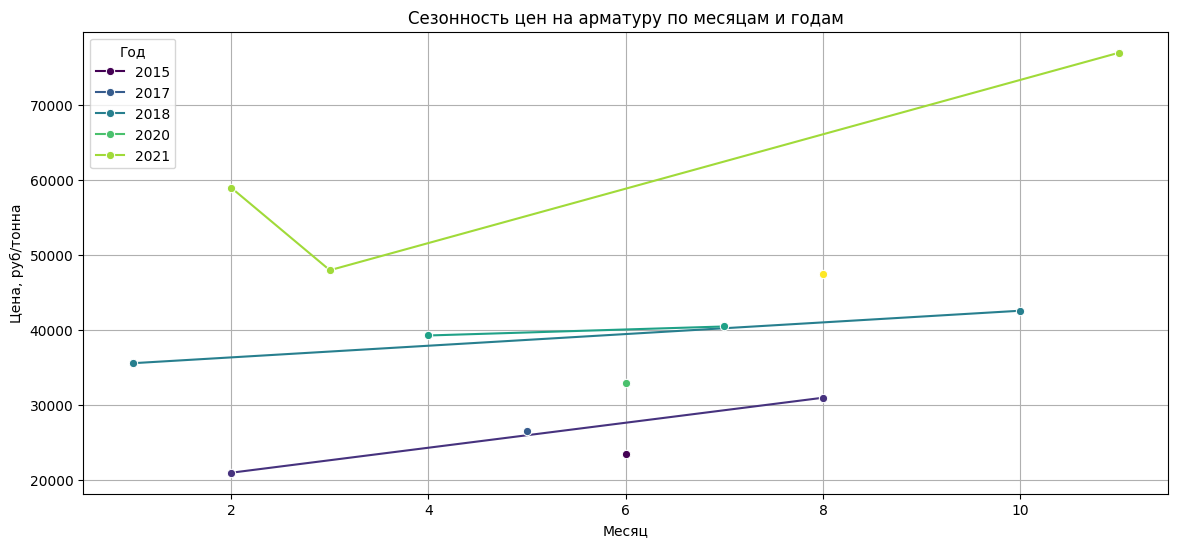

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = df.asfreq('MS')  # MS = месяц start, гарантируем месячную частоту

# График за несколько лет для выявления паттернов
plt.figure(figsize=(14, 6))
sns.lineplot(data=df, x=df.index.month, y='Цена на арматуру',
             hue=df.index.year, palette='viridis', marker='o')
plt.title('Сезонность цен на арматуру по месяцам и годам')
plt.xlabel('Месяц')
plt.ylabel('Цена, руб/тонна')
plt.legend(title='Год')
plt.grid(True)
plt.show()

2015–2019: Плавный рост цен.

2020–2022: Резкое ускорение роста (возможные причины: пандемия, геополитические события).

2023: Стабилизация или слабая коррекция после пика.

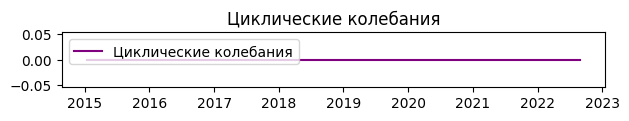

In [ ]:

# Расчёт разложения временного ряда
decomposition = sm.tsa.seasonal_decompose(df['Цена на арматуру'], model='additive', period=1)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Циклические колебания можно оценить как скользящая средняя остатков
cyclical = residual.rolling(window=2, center=True).mean()  # Используем скользящую среднюю

plt.subplot(515)
plt.plot(cyclical, label='Циклические колебания', color='purple')
plt.legend(loc='upper left')
plt.title('Циклические колебания')

plt.tight_layout()  # Обеспечивает хорошее размещение подграфиков
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


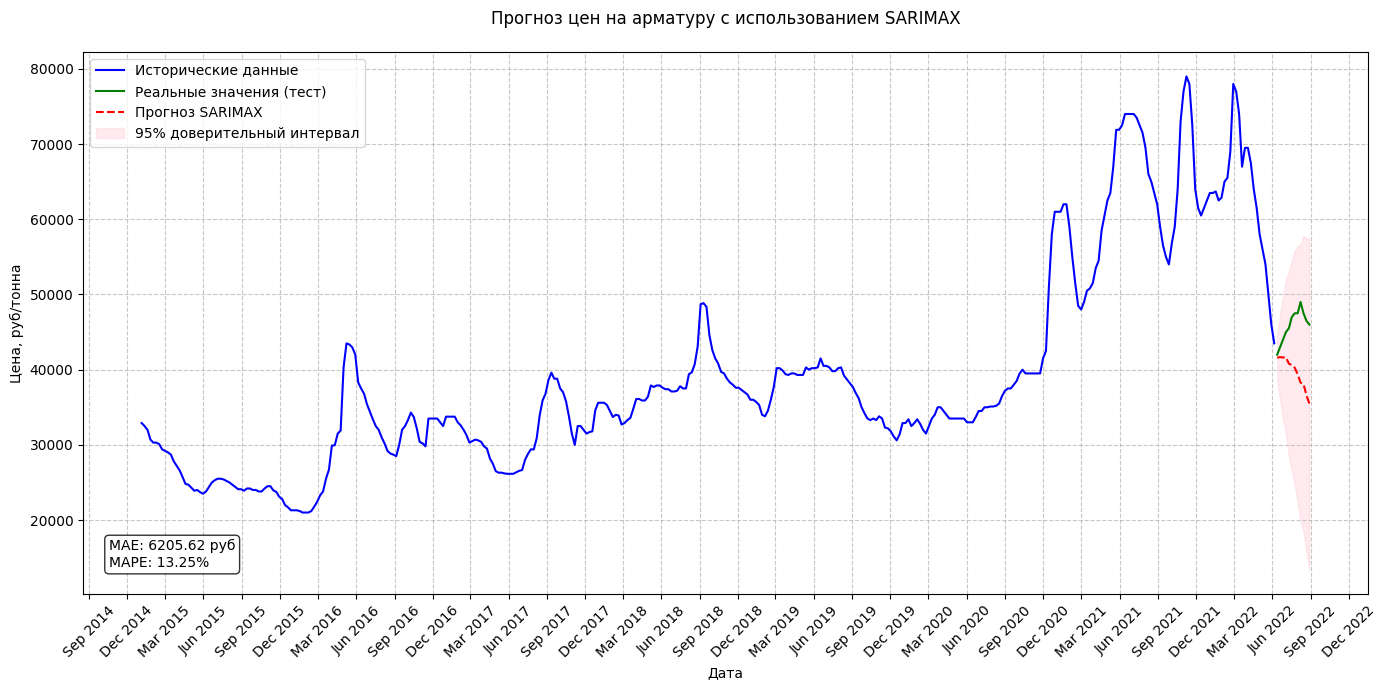

                                     SARIMAX Results                                      
Dep. Variable:                   Цена на арматуру   No. Observations:                  388
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -3182.484
Date:                            Tue, 25 Mar 2025   AIC                           6376.968
Time:                                    09:04:16   BIC                           6400.301
Sample:                                01-05-2015   HQIC                          6386.244
                                     - 06-06-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift         -0.0628      0.073     -0.864      0.388      -0.205       0.080
ar.L1          0.5378      0.062   

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Разделение на тренировочные и тестовые данные (последние 12 месяцев для проверки)
train = df.iloc[:-12]
test = df.iloc[-12:]

# Обучение модели SARIMAX
model = SARIMAX(train['Цена на арматуру'],
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 12),
                trend='t',
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit(disp=False)

# Прогноз на 12 месяцев вперед
forecast = results.get_forecast(steps=12)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Визуализация
plt.figure(figsize=(14, 7))

# Исторические данные
plt.plot(train.index, train['Цена на арматуру'], label='Исторические данные', color='blue')

# Тестовые данные (если есть)
if len(test) > 0:
    plt.plot(test.index, test['Цена на арматуру'], label='Реальные значения (тест)', color='green')

# Прогноз
plt.plot(forecast_mean.index, forecast_mean, label='Прогноз SARIMAX', color='red', linestyle='--')

# Доверительный интервал
plt.fill_between(conf_int.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='pink', alpha=0.3, label='95% доверительный интервал')

# Настройка отображения дат
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

# Оформление
plt.title('Прогноз цен на арматуру с использованием SARIMAX', pad=20)
plt.xlabel('Дата')
plt.ylabel('Цена, руб/тонна')
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Добавление метрик качества (если есть тестовые данные)
if len(test) > 0:
    from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
    mae = mean_absolute_error(test['Цена на арматуру'], forecast_mean)
    mape = mean_absolute_percentage_error(test['Цена на арматуру'], forecast_mean) * 100

    plt.annotate(f'MAE: {mae:.2f} руб\nMAPE: {mape:.2f}%',
                 xy=(0.02, 0.05),
                 xycoords='axes fraction',
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.show()

# Вывод параметров модели
print(results.summary())

## **Модель корректно уловила общее направление движения цен (рост/падение).**

## **В пиковых точках (например, конец 2022 г.) наблюдаются наибольшие расхождения между прогнозом и реальностью – это типично для периодов высокой волатильности.**
# **но метрики хуже,чем хотелось бы**